# Peptides classification with subsequence string kernel

This notebook details the utilization of Scikit-Learn to search for the best Support Vector Machine (SVM) model for the classification of peptides sequences using the subsequence string kernel.

## 1. Dataset preparation

This example is about antimicrobial peptides classification. We used the data and experimental methodology of the research conducted by P. Bhadra and collaborators.

The data consists of a dataset with a 1:3 positive to negative ratio, AMP/non-AMP peptide sequences. The dataset containing AMP and non-AMP data is freely available at https://sourceforge.net/projects/axpep/files/. 

The original work employs a 10-fold cross-validation for training a Random Forest model and obtains an Matthews correlation coefficient (MCC) score of 0.90 and an area under the receiver operating characteristic curve (AUROC) of 0.98.

**Reference**: P. Bhadra, J. Yan, J. Li, S. Fong, and S. W. Siu. AmPEP: Sequence-based prediction of antimicrobial peptides using distribution patterns of amino acid properties and random forest. *Scientific Reports*, vol. 8, no. 1, pp. 1–10, 2018.

Loading required packages.

In [21]:
from os import path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (make_scorer, 
                             matthews_corrcoef,
                             accuracy_score,
                             recall_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve)

from strkernels import SubsequenceStringKernel

random_seed = 1708  # for reproducing data splits

The first step involves loading the dataset and creating a dataframe.

In [2]:
# defining a function to create a dataframe from a FASTA file.

def read_fasta_to_dataframe(fasta_file):
    data = []
    with open(fasta_file, 'r') as file:
        sequence_id = None
        sequence = []
        
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id is not None:
                    data.append([sequence_id, ''.join(sequence)])
                sequence_id = line[1:]
                sequence = []
            else:
                sequence.append(line)
        
        if sequence_id is not None:
            data.append([sequence_id, ''.join(sequence)])
    
    df = pd.DataFrame(data, columns=['seqid', 'sequence'])
    return df

Loading the positive sequences.

In [3]:
amp_seqs_file_path = path.join('data', 'Bhadra-et-al-2018', 'train_AMP_3268.fasta')
amp_df = read_fasta_to_dataframe(amp_seqs_file_path)
amp_df['label'] = 1
amp_df

,seqid,sequence,label
0,AMP_1,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,1
1,AMP_2,AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...,1
2,AMP_3,AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTN...,1
3,AMP_4,AAFRGCWTKNYSPKPCL,1
4,AMP_5,AAGMGFFGAR,1
...,...,...,...
3263,AMP_3264,YIRDFITRRPPFGNI,1
3264,AMP_3265,GILDALTGIL,1
3265,AMP_3266,IFKAIWSGIKRLC,1
3266,AMP_3267,ILGKFCDEIKRIV,1


Loading the negative sequences.

In [4]:
amp_seqs_file_path = path.join('data', 'Bhadra-et-al-2018', 'train_nonAMP_9777.fasta')
non_amp_df = read_fasta_to_dataframe(amp_seqs_file_path)
non_amp_df['label'] = -1
non_amp_df

,seqid,sequence,label
0,nonamp_1,MNNNTTAPTYTLRGLQLIGWRDMQHALDYLFADGHLKQGTLVAINA...,-1
1,nonamp_2,MKSLLPLAILAALAVAALCYESHESMESYEVSPFTTRRNANTFISP...,-1
2,nonamp_3,MASVTDGKTGIKDASDQNFDYMFKLLIIGNSSVGKTSFLFRYADDT...,-1
3,nonamp_4,MASFQDRAQHTIAQLDKELSKYPVLNNLERQTSVPKVYVILGLVGI...,-1
4,nonamp_5,MRHRSGLRKLNRTSSHRQAMFRNMANSLLRHEVIKTTLPKAKELRR...,-1
...,...,...,...
9772,nonamp_9773,MDNEMTLTFLALSENEALARVAVTGFIAQLDPTIDELSEFKTVVSE...,-1
9773,nonamp_9774,MSKTVVRKNESLDDALRRFKRSVSKAGTLQESRKREFYEKPSVKRK...,-1
9774,nonamp_9775,MRHLVLIGFMGSGKSSLAQELGLALKLEVLDTDMIISERVGLSVRE...,-1
9775,nonamp_9776,MRDLKTYLSVAPVLSTLWFGSLAGLLIEINRFFPDALTFPFFLIRV...,-1


Creating a single dataframe with the positive and negative sequences.

In [5]:
data_df = pd.concat([amp_df, non_amp_df])
data_df

,seqid,sequence,label
0,AMP_1,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,1
1,AMP_2,AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...,1
2,AMP_3,AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTN...,1
3,AMP_4,AAFRGCWTKNYSPKPCL,1
4,AMP_5,AAGMGFFGAR,1
...,...,...,...
9772,nonamp_9773,MDNEMTLTFLALSENEALARVAVTGFIAQLDPTIDELSEFKTVVSE...,-1
9773,nonamp_9774,MSKTVVRKNESLDDALRRFKRSVSKAGTLQESRKREFYEKPSVKRK...,-1
9774,nonamp_9775,MRHLVLIGFMGSGKSSLAQELGLALKLEVLDTDMIISERVGLSVRE...,-1
9775,nonamp_9776,MRDLKTYLSVAPVLSTLWFGSLAGLLIEINRFFPDALTFPFFLIRV...,-1


## 2. Hyperparameters selection

Now, we will search for the best value for the hyperparameters maximum subsequence length (maxlen) and decay factor (ssk_lambda) of the subsequence string kernel for this dataset. 

For better performance, we will only use 10% of the samples in hyperparameter selection.

In [6]:
sampled_amp_df = amp_df.sample(n=len(amp_df) // 10, random_state=random_seed)
sampled_amp_df

,seqid,sequence,label
2969,AMP_2970,RECKTESNTFPGICITKPPCRKACISEKFTDGHCSKILRRCLCTKPC,1
2415,AMP_2416,RMRRSKSGKGSGGSKGSGSKGSKGSKGSGSKGSGSKGGSRPGGGSS...,1
1121,AMP_1122,GLFDIIKKIAESI,1
204,AMP_205,AVDFSSCARMDVPGLSKVAQGLCISSCKFQNCGTGHCEKRGGRPTC...,1
2680,AMP_2681,TLYRRFLCKKMKGRCETACLSFEKKIGTCRADLTPLCCKEKKKH,1
...,...,...,...
700,AMP_701,FLSLIPHAINAVSAIAKHN,1
2692,AMP_2693,TSRCIFYRRKKCS,1
378,AMP_379,EGVRSYLSCWGNRGICLLNRCPGRMRQIGTCLAPRVKCCR,1
1097,AMP_1098,GKIYEQCELAREFKRHGMDGYHGYSLGDWVCTAKHESNFNTAATNY...,1


In [7]:
sampled_non_amp_df = non_amp_df.sample(n=len(non_amp_df) // 10, random_state=random_seed)
sampled_non_amp_df

,seqid,sequence,label
8753,nonamp_8754,MIHKLTSEERKTRLEGLPHWTAVPGRDAIQRSLRFADFNEAFGFMT...,-1
8257,nonamp_8258,MFLNTIKPGEGAKHAKRRVGRGIGSGLGKTAGRGHKGQKSRSGGFH...,-1
5885,nonamp_5886,MYQPDFPPVPFRLGLYPVVDSVQWIERLLDAGVRTLQLRIKDRRDE...,-1
369,nonamp_370,MSFKNPVLGLCQQAAFMLSAARVDQCPADDGLEVAFAGRSNAGKSS...,-1
6825,nonamp_6826,MRVKATLINFKSKLSKSCNRFVSLFRFRVKRPVFIRPLRARHGNVK...,-1
...,...,...,...
9394,nonamp_9395,MSLCELAASGSSLLWPRVLLFGDSITQFSFQQGGWGTLLADRLVRK...,-1
5287,nonamp_5288,MGRFISVSFGLLVVFLSLSGTGADCPSEWSSHEGHCYKVFKLLKTW...,-1
6816,nonamp_6817,MYRMQLLSCIALTLALVANGAPTSSSTGNTMKEVKSLLLDLQLLLE...,-1
7319,nonamp_7320,MDIMKDKIRQALSELDILATEVQIDQWLDYLKLLEKWNKVYNMTAI...,-1


In [8]:
sampled_data_df = pd.concat([sampled_amp_df, sampled_non_amp_df])
sampled_data_df

,seqid,sequence,label
2969,AMP_2970,RECKTESNTFPGICITKPPCRKACISEKFTDGHCSKILRRCLCTKPC,1
2415,AMP_2416,RMRRSKSGKGSGGSKGSGSKGSKGSKGSGSKGSGSKGGSRPGGGSS...,1
1121,AMP_1122,GLFDIIKKIAESI,1
204,AMP_205,AVDFSSCARMDVPGLSKVAQGLCISSCKFQNCGTGHCEKRGGRPTC...,1
2680,AMP_2681,TLYRRFLCKKMKGRCETACLSFEKKIGTCRADLTPLCCKEKKKH,1
...,...,...,...
9394,nonamp_9395,MSLCELAASGSSLLWPRVLLFGDSITQFSFQQGGWGTLLADRLVRK...,-1
5287,nonamp_5288,MGRFISVSFGLLVVFLSLSGTGADCPSEWSSHEGHCYKVFKLLKTW...,-1
6816,nonamp_6817,MYRMQLLSCIALTLALVANGAPTSSSTGNTMKEVKSLLLDLQLLLE...,-1
7319,nonamp_7320,MDIMKDKIRQALSELDILATEVQIDQWLDYLKLLEKWNKVYNMTAI...,-1


Separating sampled dataset in train and test sets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sampled_data_df['sequence'], 
                                                    sampled_data_df['label'], 
                                                    stratify=sampled_data_df['label'], 
                                                    random_state=random_seed)
print('Train sequences:',len(X_train))
print('Test sequences:',len(X_test))

Train sequences: 977
Test sequences: 326


Creating the subsequence string kernel instance.

In [10]:
subsequence_kernel = SubsequenceStringKernel()

Running grid search with 10-fold cross-validation for searching the better subsequence string kernel hyperparameters.

In [11]:
# create a support vector classifier with the kernel
clf = SVC(kernel=subsequence_kernel)

# set parameters for grid search
param_grid = {
    'kernel__maxlen': [3, 4, 5, 6, 7],
    'kernel__ssk_lambda': [0.01, 0.25, 0.5, 0.75, 1.0],
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# get the best trained model
best_model = grid_search.best_estimator_

# make predictions using the best model
predictions = best_model.predict(X_test)

# calculate MCC score
MCC_score = matthews_corrcoef(y_test, predictions)

# print the results
print("\nBest parameters:", best_params)
print("MCC score of the best model in test dataset:", MCC_score)

# save all grid search results to a CSV file with current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_grid_1 = f'grid_search_results_{current_time}.csv'
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(filename_grid_1, index=False)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[CV 2/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.742 total time= 3.2min
[CV 5/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.691 total time= 3.2min
[CV 8/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.801 total time= 3.2min
[CV 7/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.720 total time= 3.3min
[CV 6/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.822 total time= 3.3min
[CV 1/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.860 total time= 3.3min
[CV 4/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.778 total time= 3.4min
[CV 3/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.744 total time= 3.4min
[CV 1/10] END kernel__maxlen=3, kernel__ssk_lambda=0.25;, score=0.860 total time= 3.3min
[CV 2/10] END kernel__maxlen=3, kernel__ssk_lambda=0.25;, score=0.742 total time= 3.3min
[CV 9/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.710 total time= 3.4min
[CV 10/10] END kernel

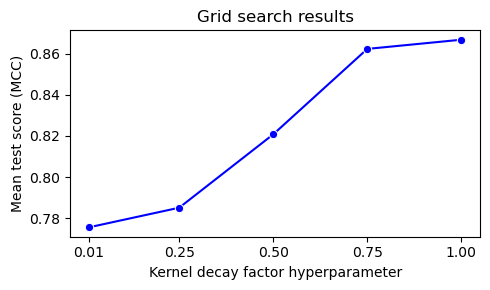

In [12]:
grid_1_results_df = pd.read_csv(filename_grid_1)
grid_1_results_df = grid_1_results_df[grid_1_results_df['param_kernel__maxlen'] == 4]

plt.figure(figsize=(5, 3))
sns.lineplot(x='param_kernel__ssk_lambda', y='mean_test_score', data=grid_1_results_df, marker='o', color='b')
plt.xticks(ticks=grid_1_results_df['param_kernel__ssk_lambda'].unique())
plt.xlabel('Kernel decay factor hyperparameter')
plt.ylabel('Mean test score (MCC)')
plt.title('Grid search results')
plt.tight_layout()
plt.show()

In [13]:
# create a support vector classifier with the kernel
clf = SVC(kernel=subsequence_kernel)

# set parameters for grid search
param_grid = {
    'kernel__maxlen': [3, 4, 5],
    'kernel__ssk_lambda': [0.8, 0.9, 1.0, 1.1, 1.2],
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# get the best trained model
best_model = grid_search.best_estimator_

# make predictions using the best model
predictions = best_model.predict(X_test)

# calculate MCC score
MCC_score = matthews_corrcoef(y_test, predictions)

# print the results
print("\nBest parameters:", best_params)
print("MCC score of the best model in test dataset:", MCC_score)

# save all grid search results to a CSV file with current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_grid_2 = f'grid_search_results_{current_time}.csv'
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(filename_grid_2, index=False)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV 1/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.916 total time= 3.3min
[CV 2/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.859 total time= 3.3min
[CV 8/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.801 total time= 3.3min
[CV 7/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.864 total time= 3.3min
[CV 6/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.830 total time= 3.3min
[CV 5/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.807 total time= 3.4min
[CV 3/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.848 total time= 3.4min
[CV 4/10] END kernel__maxlen=3, kernel__ssk_lambda=0.8;, score=0.893 total time= 3.5min
[CV 4/10] END kernel__maxlen=3, kernel__ssk_lambda=0.9;, score=0.893 total time= 3.2min
[CV 2/10] END kernel__maxlen=3, kernel__ssk_lambda=0.9;, score=0.831 total time= 3.3min
[CV 1/10] END kernel__maxlen=3, kernel__ssk_lambda=0.9;, 

/home/denilson/anaconda3/envs/strkernels-env/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters: {'kernel__maxlen': 5, 'kernel__ssk_lambda': 1.1}
MCC score of the best model in test dataset: 0.8945488356335536


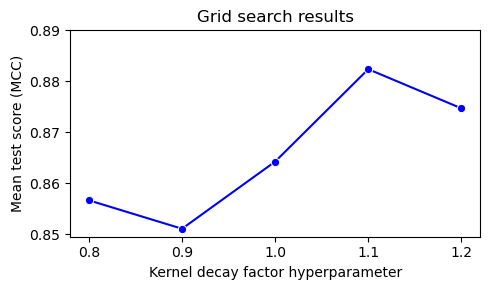

In [14]:
grid_2_results_df = pd.read_csv(filename_grid_2)
grid_2_results_df = grid_2_results_df[grid_2_results_df['param_kernel__maxlen'] == 5]

plt.figure(figsize=(5, 3))
sns.lineplot(x='param_kernel__ssk_lambda', y='mean_test_score', data=grid_2_results_df, marker='o', color='b')
plt.xticks(ticks=grid_2_results_df['param_kernel__ssk_lambda'].unique())
plt.yticks([0.85, 0.86, 0.87, 0.88, 0.89])
plt.xlabel('Kernel decay factor hyperparameter')
plt.ylabel('Mean test score (MCC)')
plt.title('Grid search results')
plt.tight_layout()
plt.show()

Searching a better C hyperparameter of SVM.

In [15]:
# set parameters for grid search
param_grid = {
    'kernel__maxlen': [5],
    'kernel__ssk_lambda': [1.1],
    'C': [0.1, 1.0, 10.0]
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# get the best trained model
best_model = grid_search.best_estimator_

# make predictions using the best model
predictions = best_model.predict(X_test)

# calculate MCC score
MCC_score = matthews_corrcoef(y_test, predictions)

# print the results
print("\nBest parameters:", best_params)
print("MCC score of the best model in test dataset:", MCC_score)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 4/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.691 total time= 4.8min
[CV 5/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.668 total time= 4.8min
[CV 6/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.891 total time= 4.8min
[CV 7/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.495 total time= 4.8min
[CV 8/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.740 total time= 4.8min
[CV 3/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.649 total time= 4.9min
[CV 1/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.861 total time= 5.0min
[CV 2/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.742 total time= 5.1min
[CV 9/10] END C=0.1, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.648 total time= 4.8min
[CV 3/10] END C=1.0, kernel__maxlen=5, kernel__ssk_lambda=1.1;, score=0.870 total ti

### 3. Best model on full dataset

Now, we will apply the best model found on the full dataset, separating 75% of the sequences for training and 25% for testing.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_df['sequence'], 
                                                    data_df['label'], 
                                                    stratify=data_df['label'], 
                                                    random_state=random_seed)
print('Train sequences:',len(X_train))
print('Test sequences:',len(X_test))

Train sequences: 9783
Test sequences: 3262


Training the model.

In [ ]:
# create a kernel
subsequence_kernel = SubsequenceStringKernel(maxlen=5, ssk_lambda=1.1)

# create a support vector classifier with the kernel
clf = SVC(C=1.0, kernel=subsequence_kernel)

# train the classifier
clf.fit(X_train, y_train)

Performing the classification on the test dataset and obtaining the scores predicted.

In [18]:
pred_scores = clf.decision_function(X_test)

Plotting the ROC curve.

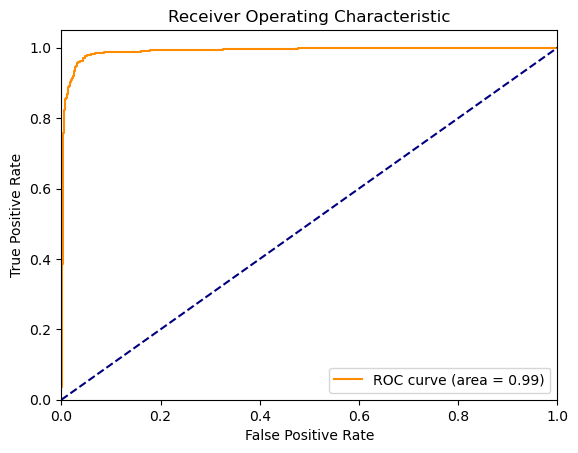

In [22]:
def plot_roc_curve(y_true, y_score):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a binary classifier.

    Args:
        y_true: True binary labels.
        y_score: Predicted probabilities or decision function scores.

    Returns:
        None
    """

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, pred_scores)

Defining sequence labels from scores.

In [19]:
pred_labels = np.where(pred_scores > 0, 1, -1)

Calculating and showing evaluation metrics.

In [20]:
MCC = round(matthews_corrcoef(y_test, pred_labels), 4)
accuracy = round(accuracy_score(y_test, pred_labels)*100, 2)
sensitivity = round(recall_score(y_test, pred_labels)*100, 2)
TN, FP, FN, TP = confusion_matrix(y_test, pred_labels).ravel()
specificity = round(TN / (TN + FP)*100, 2)
AUROC = round(roc_auc_score(y_test, pred_scores), 4)

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUROC:", AUROC)

MCC: 0.9037
Accuracy: 96.26
Sensitivity: 96.08
Specificity: 96.32
AUROC: 0.9904


We observe that the best SVM model achieved an MCC score equal to the original tool and a better AUROC score, indicating good performance for the proposed problem.